# Telecom Churn Prediction | Neural Network Classifier

## Import relevant libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Load preprocessed data

In [2]:
df_preprocessed = pd.read_csv('../data/processed/preprocessed_telco.csv')

In [3]:
df_preprocessed.head()

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,0.013889,0.115423,0.003437,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0.472222,0.385075,0.217564,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.027778,0.354229,0.012453,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0.625000,0.239303,0.211951,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.027778,0.521891,0.017462,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


## Independent and Dependent variables

In [4]:
X = df_preprocessed.drop('Churn_Yes', axis=1)
y = df_preprocessed['Churn_Yes']

In [5]:
y.value_counts()

Churn_Yes
0    5174
1    1869
Name: count, dtype: int64

## Converting data to numpy arrays

In [6]:
X = X.values
y = y.values

## Train Test Split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 30)
(1409, 30)
(5634,)
(1409,)


## Hanlde class imbalance 

In [9]:
x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

In [10]:
from imblearn.over_sampling import SMOTE

In [11]:
smote = SMOTE(random_state=42)

In [12]:
x_train_res, y_train_res = smote.fit_resample(x_train_sub, y_train_sub)

c:\Users\sanid\VS Projects\Telecom_Churn_Prediction\.venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [13]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))

Before SMOTE: Counter({np.int64(0): 4139, np.int64(1): 1495})
After SMOTE: Counter({np.int64(0): 3311, np.int64(1): 3311})


In [14]:
print(f"Training set shape: {x_train_res.shape}, {y_train_res.shape}")
print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
print(f"Test set shape: {x_test.shape}, {y_test.shape}")

Training set shape: (6622, 30), (6622,)
Validation set shape: (1127, 30), (1127,)
Test set shape: (1409, 30), (1409,)


## Neural Network Model

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train_res.shape[1],)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\sanid\VS Projects\Telecom_Churn_Prediction\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [17]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [19]:
history = model.fit(
    x_train_res,
    y_train_res, 
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6271 - auc: 0.6821 - loss: 0.6515 - val_accuracy: 0.7303 - val_auc: 0.8181 - val_loss: 0.5382
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7549 - auc: 0.8183 - loss: 0.5399 - val_accuracy: 0.7311 - val_auc: 0.8342 - val_loss: 0.5031
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7647 - auc: 0.8401 - loss: 0.4980 - val_accuracy: 0.7551 - val_auc: 0.8371 - val_loss: 0.4832
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7699 - auc: 0.8476 - loss: 0.4830 - val_accuracy: 0.7471 - val_auc: 0.8382 - val_loss: 0.4980
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7763 - auc: 0.8539 - loss: 0.4740 - val_accuracy: 0.7445 - val_auc: 0.8388 - val_loss: 0.5022
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7752 - auc: 0.8483 - loss: 0.4818 - val_accuracy: 0.7462 - val_auc: 0.8393 - val_loss: 0.5000
Epoch 7/100
207/207 ━━━━━━━━━━━━━━

## Plot loss

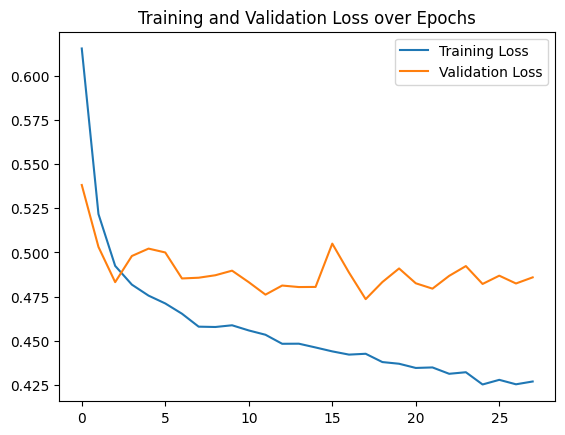

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

In [21]:
test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}, Test AUC: {test_auc:.4f}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7459 - auc: 0.8297 - loss: 0.4878 
Test Accuracy: 0.7551, Test AUC: 0.8338


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

In [23]:
y_pred_prob = model.predict(x_test)

y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409

Confusion Matrix:

[[782 253]
 [ 92 282]]


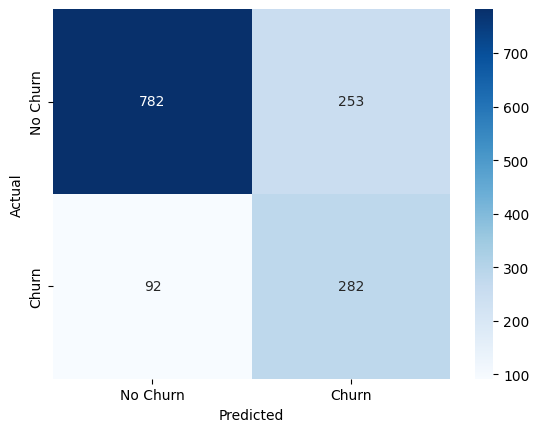

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.89      0.76      0.82      1035
       Churn       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.76      0.77      1409



45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step
ROC-AUC score: 0.8339326771551835


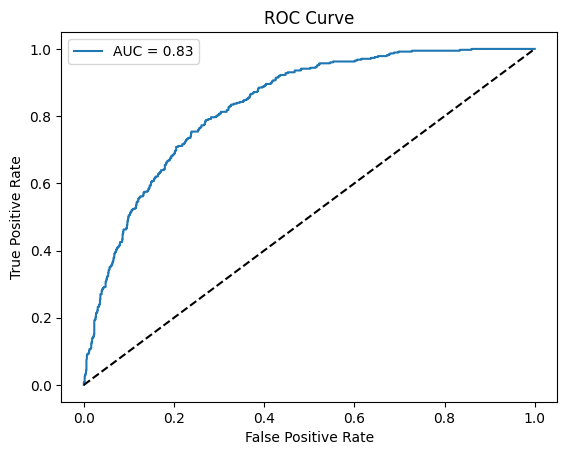

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_prob = model.predict(x_test)
auc = roc_auc_score(y_test, y_pred_prob)
print("ROC-AUC score:", auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()